### Accessing the European Central Bank DWH risk data with Python

The European Central Bank (ECB) and the European Banking Authority (EBA) have made a large amount of credit risk information available. Although much of this information is not yet in a machine-readable format, this option is becoming increasingly popular. 

See also:
- [Introduction to the ECB DWH](https://sdw-wsrest.ecb.europa.eu/help/)
- [Available data series](https://sdw.ecb.europa.eu/browseSelection.do?node=9698058)


In [118]:
import requests
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np

### A. Helper functions

In [119]:
def sup_ecb_data(countries, data_items, report_type='estimates'):
  # Query the ECB DWH for risk data

  country_list = "+".join(countries)
  item_list = "+".join(data_items)

  entrypoint = 'https://sdw-wsrest.ecb.europa.eu/service/'
  resource = 'data'
  flowRef ='SUP'

  if report_type == 'estimates':
    key = f'Q.B01.{country_list}._Z.{item_list}._T._Z._Z._Z._Z.PCT.C'
  elif report_type == 'risk_weights':
    key = f'Q.{country_list}.W0._Z.{item_list}._T._Z._Z._Z._Z.PCT.C'

  # Define the parameters
  params = {
      'startPeriod': '2000-01-01',  # Start date of the time series
      'endPeriod': '2022-10-01'     # End of the time series
            }

  # Create the query
  request_url = entrypoint + resource + '/'+ flowRef + '/' + key

  # Make the HTTP request
  return requests.get(request_url, params=params, headers={'Accept': 'text/csv'})


def createPlots(df, group_label, first_dim, second_dim, title):
  # create the scatter plot and add group names next to the datapoints
  for group, name in df.groupby(group_label):
      plt.scatter(name[first_dim], name[second_dim], label=group)

  for i, txt in enumerate(df[group_label]):
      plt.annotate(txt, 
                  (df[first_dim][i], 
                  df[second_dim][i]), 
                  xytext=(10,0), 
                  textcoords='offset points')

  # Add info and show the plot
  plt.xlabel(f'{first_dim} (%)')
  plt.ylabel(f'{second_dim} (%)')
  plt.title(f'{title}', y =1.1)

  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)

### B. View available time series

In [120]:
# Source: https://sdw.ecb.europa.eu/datastructure.do?conceptMnemonic=CB_ITEM&datasetinstanceid=359#cl
data_catalogue = pd.read_csv('ecb_dwh_data_catalogue.csv', sep='\t', encoding='utf-8')
data_catalogue.head()

,Unnamed: 0,Label,Key,From,To,Last Updated,Frequency,Country,Item,Country.1,Data type,Balance sheet suffix,Long description
0,0,TOTAL RISK EXPOSURE AMOUNT / TOTAL EXPOSURES,SUP.Q.AT.W0._Z.E0000._T._Z._Z.ALL.LE.E.C,2015Q2,2022Q3,2023-01-11 10:00:00,Q,AT,E0000,ALL,LE,E,"Austria, World (all entities, including refer..."
1,1,"TOTAL EXPOSURES FOR CREDIT, COUNTERPARTY CREDI...",SUP.Q.AT.W0._Z.E1000._T._Z._Z.ALL.LE.E.C,2015Q2,2022Q3,2023-01-11 10:00:00,Q,AT,E1000,ALL,LE,E,"Austria, World (all entities, including refer..."
2,2,Exposures to credit risk - Risk exposure amoun...,SUP.Q.AT.W0._Z.E1100._T._Z._Z.ALL.LE.E.C,2015Q2,2022Q3,2023-01-11 10:00:00,Q,AT,E1100,ALL,LE,E,"Austria, World (all entities, including refer..."
3,3,Securitisation positions,SUP.Q.AT.W0._Z.E1300._T._Z._Z.ALL.LE.E.C,2020Q1,2022Q3,2023-01-11 10:00:00,Q,AT,E1300,ALL,LE,E,"Austria, World (all entities, including refer..."
4,4,Exposures to credit risk - Standardised approa...,SUP.Q.AT.W0._Z.E2000._T._Z._Z.ALL.LE.E.C,2015Q2,2022Q3,2023-01-11 10:00:00,Q,AT,E2000,ALL,LE,E,"Austria, World (all entities, including refer..."


### C. Get PD, LGD and RWA data

In [121]:
# Get PD and LGD data
countries = ['ES', 'DE', 'FR', 'IT', 'EE', 'SE', 
             'IT', 'NL', 'CH', 'FI', 'BE']
data_items = ['EPD05', 'EL005']

# Request
response = sup_ecb_data(countries, data_items, report_type='estimates')

# Read the response as a file into a Pandas DataFrame
est_data = pd.read_csv(io.StringIO(response.text))

est_data = est_data[['TIME_PERIOD', 'TITLE', 'TITLE_COMPL', 'COUNT_AREA', 'OBS_VALUE']]
est_data.columns = ['SnapshotDate', 'Item', 'Description', 'Area', 'Value']

In [122]:
# Get RWA data
countries = ['ES', 'DE', 'FR', 'IT', 'EE', 'SE', 
             'IT', 'NL', 'CH', 'FI', 'BE']
data_items = ['EW24R']

# Request
response = sup_ecb_data(countries, data_items, report_type='risk_weights')

# Read the response as a file into a Pandas DataFrame
rwa_data = pd.read_csv(io.StringIO(response.text))

rwa_data = rwa_data[['TIME_PERIOD', 'TITLE', 'TITLE_COMPL', 'REF_AREA', 'OBS_VALUE']]
rwa_data.columns = ['SnapshotDate', 'Item', 'Description', 'Area', 'Value']

In [123]:
# Join datasets
full_ds = pd.concat([est_data, rwa_data])

# Filter dataframe by date and create the dataset for plotting
snapshot_date = '2022-Q3'
full_dataset = full_ds[full_ds['SnapshotDate'] == snapshot_date]

# Prepare data for plotting
summary = full_ds.groupby(['Area', 'Item']).agg({'Value': ['max']}).unstack().reset_index()
summary.columns = ['Area', 'LGD', 'PD', 'RWA']

# Enrich data
summary['EL'] = summary['PD'] * summary['LGD'] / 100

summary

,Area,LGD,PD,RWA,EL
0,BE,14.23,0.99,12.78,0.140877
1,CH,20.80,0.88,NaN,0.183040
2,DE,18.79,1.03,16.78,0.193537
3,EE,NaN,NaN,NaN,NaN
4,ES,21.69,1.31,17.79,0.284139
5,FI,21.59,0.99,7.98,0.213741
6,FR,13.18,1.09,15.46,0.143662
7,IT,20.70,1.58,19.19,0.327060
8,NL,16.08,0.62,14.77,0.099696


### D. Create graphs

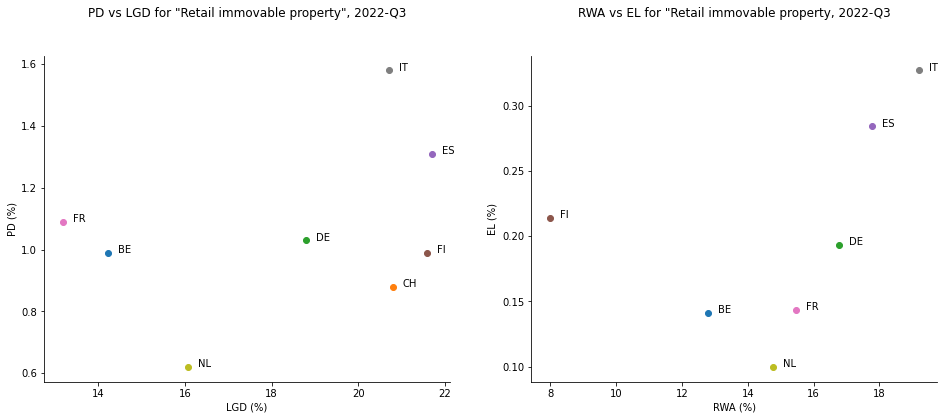

In [124]:
# Create graphs
plt.figure(figsize=(16, 6)) 
plt.subplot(1, 2, 1) # row 1, col 2 index 1

# PD/LGD graph
group_label = 'Area'
first_dim = 'LGD'
second_dim = 'PD'
title = f'PD vs LGD for "Retail immovable property", {snapshot_date}'

createPlots(summary, group_label, first_dim, second_dim, title)

plt.subplot(1, 2, 2) # row 1, col 2 index 1

# RWA graph
group_label = 'Area'
first_dim = 'RWA'
second_dim = 'EL'
title = f'RWA vs EL for "Retail immovable property, {snapshot_date}'

createPlots(summary, group_label, first_dim, second_dim, title)

plt.show()